# Hawkes LSTM model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [3]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys
import glob
import tqdm

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


## Loading synthetic data

We will be loading simulated Hawkes data.

In [7]:
import glob
import pickle

SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181201-002801.pkl


In [8]:
# SET THESE PARAMETERS
process_dim = 1
print("Process dimension: {}".format(process_dim))
choose_file_index = 0
chosen_data_file = SYNTH_DATA_FILES[choose_file_index]
print("Data file: {}".format(chosen_data_file))

Process dimension: 1
Data file: ../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl


In [9]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)

Loading 1-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	1.0
alpha	0.2
decay	3.0
tmax	80.0


In [10]:
print(seq_lengths.shape)

torch.Size([6000])


## Training

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t))
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$

with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [11]:
import models.ctlstm
from models.ctlstm import HawkesLSTM, HawkesLSTMGen
from train_functions import train_lstm, plot_loss

In [12]:
# define training data
train_size = 2000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 2000
Train event times shape torch.Size([2000, 158])
Train event types shape torch.Size([2000, 158])
Train seq lengths shape torch.Size([2000])


In [ ]:
process_dim = 1
hidden_size = 32
model = HawkesLSTM(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.025)

# Training parameters
BATCH_SIZE = 64
EPOCHS = 10

loss_hist, train_hist = train_lstm(model, optimizer, train_times_tensor,
                                   train_seq_types, train_seq_lengths, tmax,
                                   BATCH_SIZE, EPOCHS, use_jupyter=True)

Batch size 64
Number of epochs 10



epoch 1: train loss 88.4917



epoch 2: train loss 77.1012



epoch 3: train loss 76.6745



epoch 4: train loss 76.5070



epoch 5: train loss 76.3986



epoch 6: train loss 76.3228



epoch 7: train loss 76.2672



epoch 8: train loss 76.2252



epoch 9: train loss 76.1926


In [ ]:
_ = plot_loss(EPOCHS, loss_hist)

In [22]:
import datetime
# Generate save params to record the model
# Model file dump
SAVED_MODELS_PATH = '../saved_models'
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

In [24]:
# This cell resets the timestamp !!
date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)

In [27]:
train_hist[-1]['decay_cell'][-2:]

[tensor([[0.0037],
         [0.0037],
         [0.0037],
         [0.0037],
         [0.0037]], grad_fn=<SoftplusBackward>), tensor([[0.0037],
         [0.0037]], grad_fn=<SoftplusBackward>)]

Now we save the model down to a file.

In [156]:
from utils.save_model import save_model

save_model(model, chosen_data_file, extra_tag, hidden_size, now_timestamp)

## Model evaluation

Now we perform model evaluation steps.

### Load saved model

In [161]:
from models import HawkesLSTM

In [13]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
for p in MODEL_FILES:
    print(p)

load_filename = MODEL_FILES[2]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

../saved_models/HawkesDecayRNN-2d-20181128-145645.pth
../saved_models/HawkesDecayRNN-1d_hidden8-20181202-140621.pth
../saved_models/HawkesLSTM-1d_hidden32-20181203-005804.pth
../saved_models/HawkesDecayRNN-1d_hidden32-20181202-141923.pth
chosen file: ../saved_models/HawkesLSTM-1d_hidden32-20181203-005804.pth
20181203-005804


In [14]:
process_dim = 1
hidden_size = 32
print("Hidden size: {}".format(hidden_size))
model = HawkesLSTM(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 32


### Sequence generation and sequence length distribution

In [15]:
from models.ctlstm import HawkesLSTMGen

In [16]:
neural_gen = HawkesLSTMGen(model)

Process model dim:	1	Hidden units:	24


no. of events: 102


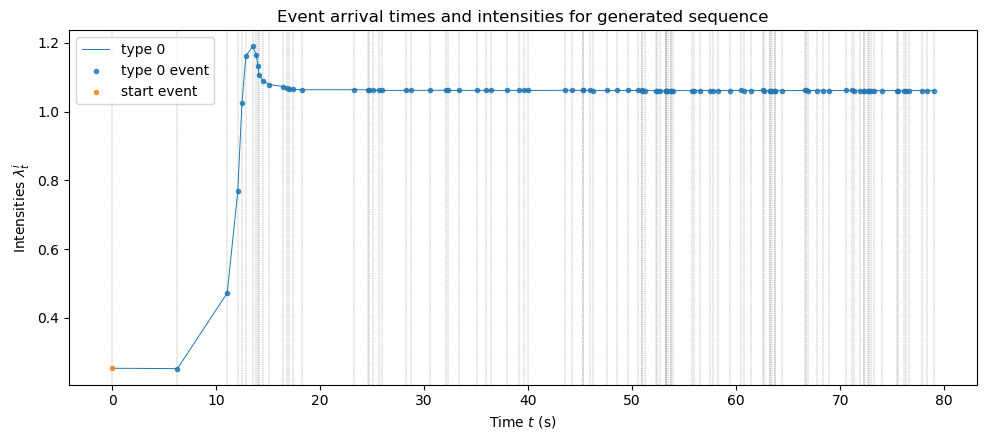

In [26]:
neural_gen.generate_sequence(tmax)

_ = neural_gen.plot_events_and_intensity()